In [1]:
# %load_ext memory_profiler

# Benchmark V4 model

Fork: benchmarkV3
benchmarkV3 but tokenizer configured like Benchmark
- glove.840B.300d


The validation F1-score is 0.6656 at a threshold of 0.26.

In [2]:
import keras
print (keras.__version__)

Using TensorFlow backend.


2.2.4


# Constants

In [3]:
MODEL_VERSION = 'benchmarkV4'
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
MAX_WORDS = 50000

## Common english contraction mappings (wikipedia):
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [4]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [5]:
PUNCT = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [6]:
SPECIAL_PUNCT = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

In [7]:
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [8]:
MISPELL_MAPPING = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

# Helpers

## Embedding helpers

In [9]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [10]:
def loadEmbeddingsGensim(path, dimensions, binary=True):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    gensim_vecs = KeyedVectors.load_word2vec_format(path, binary=binary)
    for word, vector in zip(gensim_vecs.vocab, gensim_vecs.vectors):
        coefs = np.asarray(vector[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [11]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Helper to replace contractions in dataset

In [12]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([CONTRACTION_MAPPING[t] if t in CONTRACTION_MAPPING else t for t in text.split(" ")])
    return text

### Helper to remap punctuations in dataset

In [13]:
def clean_special_chars(text):
    for p in PUNCT_MAPPING:
        text = text.replace(p, PUNCT_MAPPING[p])
    
    for p in PUNCT:
        text = text.replace(p, ' ' + p + ' ')
    
    for s in SPECIAL_PUNCT:
        text = text.replace(s, SPECIAL_PUNCT[s])
    
    return text

### Helper to correct common mispellings

In [14]:
def correct_spelling(x):
    for word in MISPELL_MAPPING.keys():
        x = x.replace(word, MISPELL_MAPPING[word])
    return x

## Coverage helpers

In [15]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [16]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [17]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

# Analyze train and test data

In [18]:
print("Sample insincere questions")
train_df.loc[train_df['target'] == 1].sample(10)

Sample insincere questions


,qid,question_text,target
533875,688c2d2b3b6989e32cc5,"After Trump, can rich people continue to get poor white people to vote against their own economic interests?",1
701157,894a228d950b3f6afaee,"How can Lutherans state they follow the Bible, but yet allow homosexuals to pastor churches and lead?",1
805940,9de87d81e6c84d185afd,"If God lives without a body, would he be an alcoholic and a drug addict, given that he can eliminate side effects instantly? If no, what would be some reasons why he would refrain from such behavior?",1
638490,7d0fbcce5972d785a57a,How do I get rid of Indians on Quora?,1
1214810,ee196b1e1d86264c72f5,"Why are liberals so uninformed (arguments based on emotions, not fact)?",1
1189619,e91f54da2904307f30bd,How do you feel after having sexual relations with your sister?,1
798871,9c89d3bd751fa017f460,"I just won 2 back-to-back games of PUBG, am I God?",1
272019,353f8127bd7a39eb091a,Why does Turkey terrorise the Kurds?,1
310949,3ce895cd2c22010c63de,In what way are Muslim girls in India better than Hindu girls in terms of culture and tradition?,1
992086,c264b01c08c3e5aec209,Why are atheists so ignorant? Can't they just believe in God?,1


In [19]:
print("Sample sincere questions")
train_df.loc[train_df['target'] == 0].sample(10)

Sample sincere questions


,qid,question_text,target
1249928,f4f28968c197077cfa0d,Why everyone is writing such a long answer for every little question?,0
6932,01595c14b02448679dbd,What are the career options after post-graduate diploma in disaster management from TISS?,0
1289385,fcb4202868117103e878,How can one tell if a person have 4 cone cells in his/her eye?,0
125298,1885c9990e53586c79cf,Which video game characters from Xbox 360 or Xbox One do you think could the perfect shipping couples?,0
1006052,c526f590782bcc4d8713,What training did Dennis Dixon do to become a professional American football player?,0
452807,58b2a3400d5ebb5bbd2d,Can you love someone blindly?,0
997230,c3697a5eefd8f6ee13cf,How much weight do boxers lose during a fight?,0
451986,58880b8f84780a4e9947,How can I fix a trimmer?,0
1172773,e5d26a477b6777a171a7,Can signal violation be treated as rough driving?,0
515426,64ea6625904ff4421c9a,What are the best in-ear nose-isolating headphones to use to block noisy kids?,0


In [20]:
import matplotlib.pyplot as plt
import numpy as np

target_ratios = train_df.target.value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios (target)')
plt.show()

0    0.93813
1    0.06187
Name: target, dtype: float64


<Figure size 640x480 with 1 Axes>

In [21]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [22]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [23]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


In [24]:
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x)))))
print('Max character length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x)))))

Max character length of questions in train is 1017.
Max character length of questions in test is 588.


In [25]:
print('p999 character length of questions in train is {0:.0f}.'.format(np.percentile(train_df['question_text'].apply(lambda x: len(x)), 99.9)))
print('p999 character length of questions in test is {0:.0f}.'.format(np.percentile(test_df['question_text'].apply(lambda x: len(x)), 99.9)))

p999 character length of questions in train is 249.
p999 character length of questions in test is 249.


# Data processing


## TODO: Feature engineering

Add feature engineering here.

In [26]:
%%time

train_df['treated_question'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_contractions(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: correct_spelling(x))

test_df['treated_question'] = test_df['question_text'].apply(lambda x: x.lower())
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_contractions(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_special_chars(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: correct_spelling(x))

CPU times: user 51.6 s, sys: 308 ms, total: 51.9 s
Wall time: 51.9 s


## Fill data

In [27]:
X_train = train_df['treated_question'].fillna('+++').tolist()
y_train = train_df['target']
X_test = test_df['treated_question'].fillna('+++').tolist()


print('Found %s training questions.' % len(X_train))
print('Found %s test questions.' % len(X_test))

Found 1306122 training questions.
Found 56370 test questions.


In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS)
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Shape of X_train: (1306122, 100)
Shape of y_train: (1306122,)
Found 195934 unique tokens.


## Save tokenized data + word index

In [29]:
%%time

import gc
import pickle

test_df.to_pickle('test_df.pkl')

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_pickle('y_train.pkl')

pickle.dump(word_index, open('word_index.pkl', 'wb'))

del X_train
del X_test
del y_train

gc.collect()


CPU times: user 228 ms, sys: 428 ms, total: 656 ms
Wall time: 2.72 s


## Build vocabulary with counts

In [30]:
%%time

train_vocab = build_vocab(train_df['treated_question'])
del train_df
test_vocab = build_vocab(test_df['treated_question'])
del test_df

vocab = train_vocab + test_vocab
del train_vocab
del test_vocab

CPU times: user 13 s, sys: 364 ms, total: 13.3 s
Wall time: 13.3 s


## Load embeddings, measure coverage and save embedding matrix

# Restore point (optional)

In [31]:
'''
%%time

import pickle

word_index = pickle.load(open('word_index.pkl', 'rb'))
'''

"\n%%time\n\nimport pickle\n\nword_index = pickle.load(open('word_index.pkl', 'rb'))\n"

In [32]:
%%time

import gc

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('glove.npy', embedding_matrix)

glove:
Loading embeddings from: ../input/embeddings/glove.840B.300d/glove.840B.300d.txt
Found 2195892 word vectors.
Found embeddings for 63.10% of vocab
Found embeddings for  99.39% of all text


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


CPU times: user 2min 51s, sys: 6.62 s, total: 2min 58s
Wall time: 2min 58s


In [33]:
del word_index
del vocab
gc.collect()

0

# Setup model

# Restore point

In [34]:
%%time

import numpy as np
import pandas as pd
import pickle

test_df = pd.read_pickle('test_df.pkl')

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = pd.read_pickle('y_train.pkl')


CPU times: user 36 ms, sys: 172 ms, total: 208 ms
Wall time: 207 ms


## NN: 2D CNN

In [35]:
%%time 

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D

filter_sizes = [1,2,3,5]
num_filters = 42

inp = Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inp)
#    x = SpatialDropout1D(0.4)(x)
x = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(x)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM),
                             kernel_initializer='he_normal', activation='tanh')(x)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM),
                             kernel_initializer='he_normal', activation='tanh')(x)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                             kernel_initializer='he_normal', activation='tanh')(x)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], EMBEDDING_DIM),
                             kernel_initializer='he_normal', activation='tanh')(x)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1))(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1))(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1))(conv_2)
maxpool_3 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[3] + 1, 1))(conv_3)

z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
z = Flatten()(z)
z = Dropout(0.1)(z)

out = Dense(1, activation="sigmoid")(z)

model = Model(inputs=inp, outputs=out)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 1, 42)   12642       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [36]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [37]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [38]:
model.save('model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [39]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint(MODEL_VERSION + '.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

In [40]:
'''
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):


    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()
'''

'\nfrom keras.callbacks import Callback\nfrom sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support\n\nclass Metrics(Callback):\n\n\n    def on_train_begin(self, logs={}):\n        self.val_f1s = []\n        self.val_recalls = []\n        self.val_precisions = []\n \n\n    def on_epoch_end(self, epoch, logs={}):\n        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()\n        val_targ = self.validation_data[1]\n        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average=\'binary\')\n        self.val_f1s.append(_val_f1)\n        self.val_recalls.append(_val_recall)\n        self.val_precisions.append(_val_precision)\n        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))\n        return\n\nmetrics = Metrics()\n'

# Compute Class Weights

Since there is a significant target inbalance.

In [41]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print (class_weights)

[0.53297527 8.08143794]


## Split train/validation

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                              random_state=233)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [43]:
%%time

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#          epochs=2, batch_size=128, callbacks=[metrics], class_weight=class_weights)

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#          epochs=2, batch_size=128, class_weight=class_weights)

# hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], epochs=8, batch_size=512)

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, epochs=3, batch_size=256)

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, initial_epoch=8, epochs=16, batch_size=512)



Train on 1044897 samples, validate on 261225 samples
Epoch 1/3
1044897/1044897 [==============================] - 66s 63us/step - loss: 0.1101 - acc: 0.9561 - f1: 0.5791 - recall: 0.5170 - precision: 0.6940 - val_loss: 0.1015 - val_acc: 0.9592 - val_f1: 0.6060 - val_recall: 0.5289 - val_precision: 0.7355

Epoch 00001: val_f1 improved from -inf to 0.60603, saving model to benchmarkV4.weights_checkpoint.h5
Epoch 2/3
1044897/1044897 [==============================] - 62s 60us/step - loss: 0.0913 - acc: 0.9633 - f1: 0.6688 - recall: 0.6243 - precision: 0.7429 - val_loss: 0.1010 - val_acc: 0.9591 - val_f1: 0.6420 - val_recall: 0.6175 - val_precision: 0.6856

Epoch 00002: val_f1 improved from 0.60603 to 0.64199, saving model to benchmarkV4.weights_checkpoint.h5
Epoch 3/3
1044897/1044897 [==============================] - 62s 59us/step - loss: 0.0763 - acc: 0.9698 - f1: 0.7333 - recall: 0.6977 - precision: 0.7905 - val_loss: 0.1055 - val_acc: 0.9584 - val_f1: 0.6157 - val_recall: 0.5591 - val

# Predict validation labels

In [44]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 3s 11us/step
CPU times: user 1.09 s, sys: 196 ms, total: 1.28 s
Wall time: 2.79 s


# Find optimal threshold

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.6260, Recall score: 0.8501, Precision score: 0.4954
Current threshold is 0.1100 with F1 score: 0.6335, Recall score: 0.8424, Precision score: 0.5076
Current threshold is 0.1200 with F1 score: 0.6390, Recall score: 0.8339, Precision score: 0.5180
Current threshold is 0.1300 with F1 score: 0.6436, Recall score: 0.8260, Precision score: 0.5272
Current threshold is 0.1400 with F1 score: 0.6475, Recall score: 0.8177, Precision score: 0.5359
Current threshold is 0.1500 with F1 score: 0.6506, Recall score: 0.8097, Precision score: 0.5438
Current threshold is 0.1600 with F1 score: 0.6532, Recall score: 0.8011, Precision score: 0.5514
Current threshold is 0.1700 with F1 score: 0.6557, Recall score: 0.7931, Precision score: 0.5588
Current threshold is 0.1800 with F1 score: 0.6582, Recall score: 0.7857, Precision score: 0.5663
Current threshold is 0.1900 with F1 score: 0.6601, Recall score: 0.7776, Precision score: 0.5734
Current threshold is 0.2000 wi

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


              precision    recall  f1-score   support

     sincere       0.98      0.97      0.98    245044
   insincere       0.61      0.73      0.67     16181

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.80      0.85      0.82    261225
weighted avg       0.96      0.95      0.96    261225



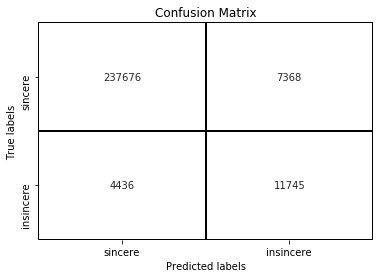

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])

plt.show()

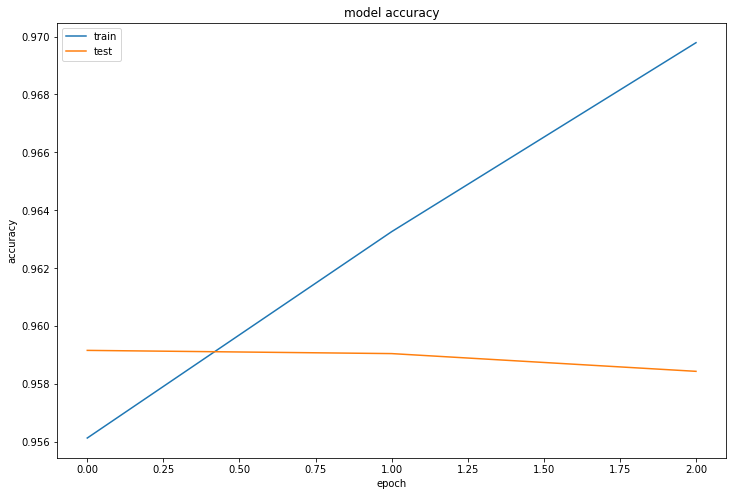

In [48]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

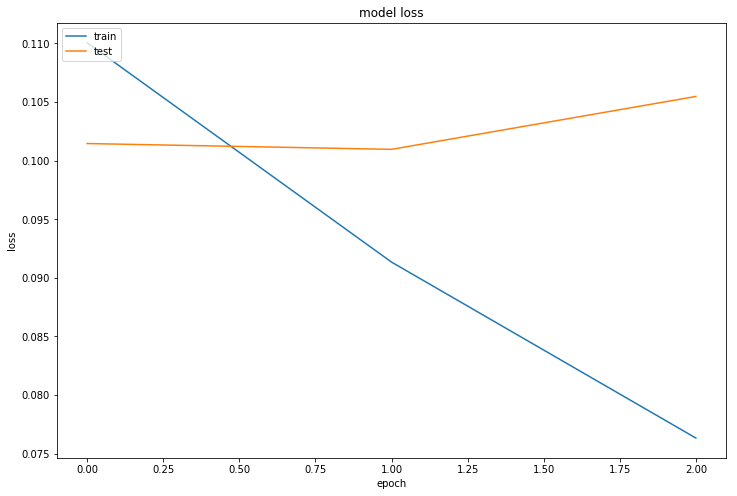

In [49]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

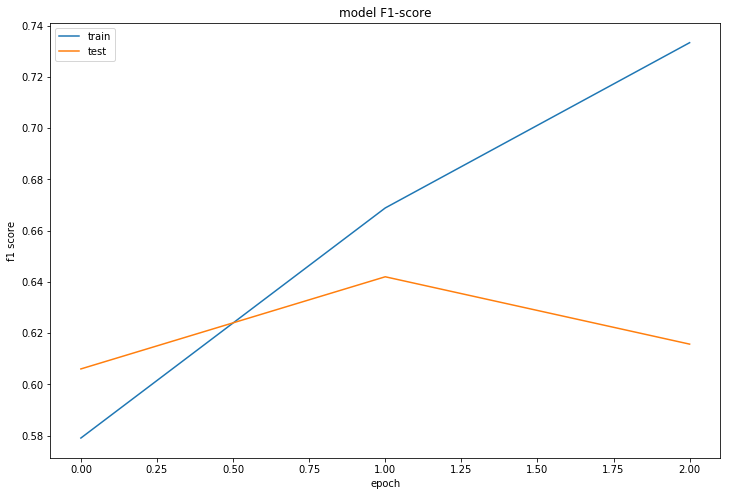

In [50]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [51]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [52]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 1s 10us/step
CPU times: user 220 ms, sys: 32 ms, total: 252 ms
Wall time: 579 ms


# Prepare submission

In [53]:
submission_df = pd.DataFrame({"qid":test_df["qid"].values})
submission_df['prediction'] = (pred_test > threshold).astype(int)
submission_df.to_csv("submission.csv", index=False)

In [54]:
type(hist)

keras.callbacks.History

In [55]:
import pickle


pickle_out = open(MODEL_VERSION + 'hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()